# Image Transformations

In [3]:
# Importing packages:
import numpy as np
import pandas as pd
import scipy.interpolate
import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import itertools
from IPython.display import Audio, display
import glob
import os 
import PIL
import albumentations as A


/opt/anaconda3/envs/02456_deep/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Setting up paths

path_real = '/Users/dabrowkaknach/Documents/DTU/02456_deep/Deeplearning-Group16/cars_real'
path_fake = '/Users/dabrowkaknach/Documents/DTU/02456_deep/Deeplearning-Group16/cars_fake'

print("Files in real images folder:", os.listdir(path_real))
print("Files in fake images folder:", os.listdir(path_fake))

Files in real images folder: ['Acura Integra Type R 2001', 'Daewoo Nubira Wagon 2002', 'Cadillac CTS-V Sedan 2012', 'Bentley Arnage Sedan 2009']
Files in fake images folder: ['Acura Integra Type R 2001', 'Daewoo Nubira Wagon 2002', 'Cadillac CTS-V Sedan 2012', 'Bentley Arnage Sedan 2009']


In [5]:
# Load paths

real_folders_paths = [os.path.join(path_real, filename) for filename in os.listdir(path_real)]
fake_folders_paths = [os.path.join(path_fake, filename) for filename in os.listdir(path_fake)]


real_images_paths = []
for folder in real_folders_paths:
    for image in os.listdir(folder):
        #if image.lower().endswith(('.jpg', '.png')):
        im_path = os.path.join(folder, image)
        real_images_paths.append(im_path)


fake_images_paths = []
for folder in fake_folders_paths:
    for image in os.listdir(folder):
        #if image.lower().endswith(('.jpg', '.png')):
        im_path = os.path.join(folder, image)
        fake_images_paths.append(im_path)


#for folder in fake_folders_paths:
    #fake_images_paths = [os.path.join(folder, image) for image in os.listdir(folder) if image.lower().endswith(('.jpg', '.png'))]


# Checking how many total images there are.
print("Total Real Images:\t", len(real_images_paths))
print("Total Fake Images:\t", len(fake_images_paths))

Total Real Images:	 64
Total Fake Images:	 64


In [6]:
# Load data

cars_real = []
for carpath in real_images_paths:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
          cars_real.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")


cars_synth = []
for carpath in fake_images_paths:
  try:
      image = cv2.imread(carpath)
      if image is not None:  # Check if loading was successful
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
      cars_synth.append(image)

  except Exception as e:
      print(f"Failed to load {carpath}: {e}")



(512, 512, 3)
uint8
(512, 512, 3)
uint8
(512, 512, 3)
uint8
(512, 512, 3)
uint8


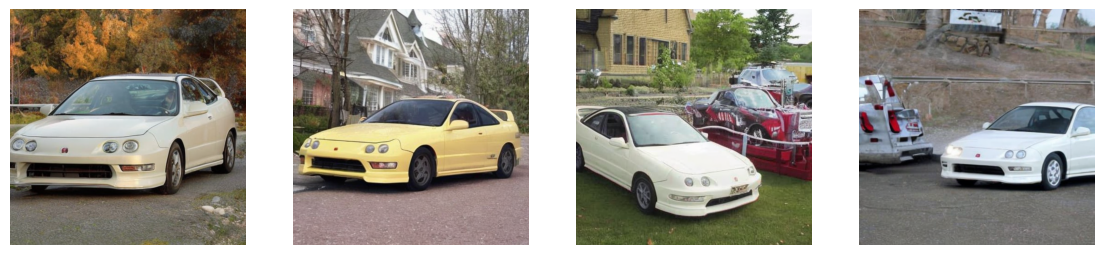

In [7]:
# Visualize examples

num_displayed_examples = 4

plt.figure(figsize=(14, 10))

for k in range(num_displayed_examples):
  plt.subplot(1, 4, k + 1)
  plt.imshow((cars_synth[k]))
  plt.axis('off')
  print(cars_synth[k].shape)
  print(cars_synth[k].dtype)


In [8]:
# Image parameters
# Based on shape of fake images
im_width = 512
im_height = 512
num_channels = 3



In [9]:
# Scaling the images 

def scale_and_shift(image): 
    # Convert from uint8 to float32 and Normalize
    #image_scaled = 2 * ((image.astype(np.float32)) / 255.0) - 1
    image_scaled = (image.astype(np.float32))/image.max() 
    return image_scaled


scaled_cars_synth = [scale_and_shift(im) for im in cars_synth]
scaled_cars_real = [scale_and_shift(im) for im in cars_real]



print("Shape of first scaled image:", scaled_cars_synth[0].shape)
print("Value range of first scaled image:", scaled_cars_synth[0].min(), "to", scaled_cars_synth[0].max())

Shape of first scaled image: (512, 512, 3)
Value range of first scaled image: 0.0 to 1.0


In [10]:
# Image augmentation using Albumentations

# Defining the augumentaton pipeline

transform = A.Compose([
    A.Resize(height=256, width=256, p=1),
    A.GaussianBlur(blur_limit=(3,7), sigma_limit=0.8, p=0.8),
    A.CenterCrop(width=im_width/2, height=im_height/2, p=0.2)
])

transformed_synth_cars = []
for image in scaled_cars_synth: 
    transformed = transform(image=image)
    transformed_synth_cars.append(transformed)



In [11]:
print("Original image shape:", scaled_cars_synth[0].shape)
print("Transformed image shape:", transformed_synth_cars[0]['image'].shape)

Original image shape: (512, 512, 3)
Transformed image shape: (256, 256, 3)


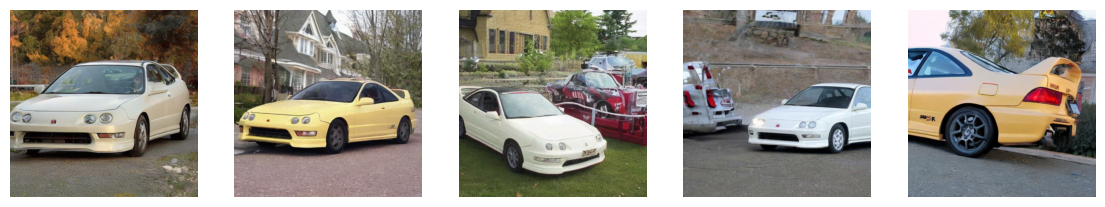

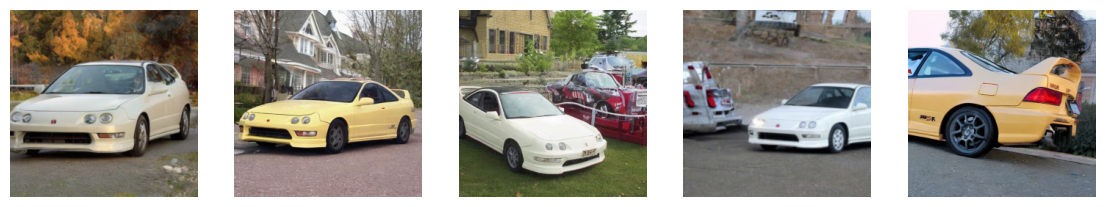

In [76]:
# Visualize examples

num_displayed_examples =  5#len(scaled_cars_synth)

plt.figure(figsize=(14, 10))
#plt.title("Original images")
#plt.axis('off')
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow((scaled_cars_synth[k]))
  plt.axis('off')


plt.figure(figsize=(14, 10))
#plt.title("Transformed images")
#plt.axis('off')
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow((transformed_synth_cars[k]['image']))
  plt.axis('off')


In [77]:
# Frequency analysis of images

pow_spec_all = []
spec_all = []


for k in range(num_displayed_examples): 

    image_data = transformed_synth_cars[k]['image']

    for channel in range(image_data.shape[2]):  # Loop over RGB channels
        channel_data = image_data[..., channel]

        # Compute power spectrum for this channel
        f_transform = np.fft.fft2(channel_data)
        f_transform_shifted = np.fft.fftshift(f_transform)
        pow_spec = np.abs(f_transform_shifted) ** 2 

        
    # Computing the power spectrum
    spec = np.fft.fftshift(np.fft.fft2(channel_data))
    spec = np.abs(spec)
    spec = np.log(spec + 1)
    spec_all.append(spec)
    

    # Creating a radial grid
    ny, nx = pow_spec.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)


    # Radial binning 
    r = r.astype(np.int32)
    r_max = r.max()
    psd = np.bincount(r.ravel(), weights=pow_spec.ravel()) / np.bincount(r.ravel())
    pow_spec_all.append(psd)    

    # Generate frequencies for plotting
    freqs = np.arange(len(psd))  # Frequencies for the PSD (normalized)

    #plt.figure(figsize=(8, 6))
    #plt.subplot(2, num_displayed_examples, k + 1)
   # plt.imshow(image_data)
    #plt.plot(freqs, psd, label="Radially Averaged PSD") #
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlabel("Frequency (log scale)")
    #plt.ylabel("Power Spectral Density (log scale)")
    #plt.title("Radially Averaged Power Spectral Density")
    #plt.grid(which="both")
    #plt.legend()
    #plt.show()




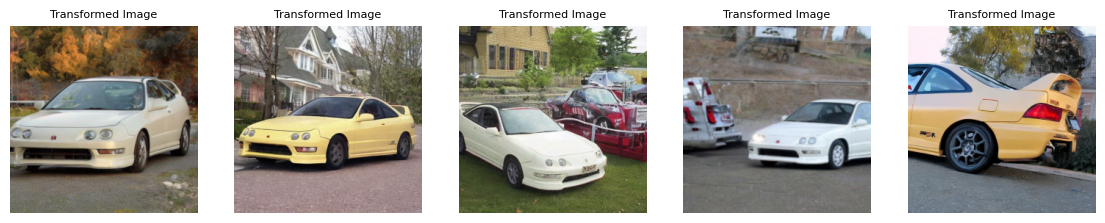

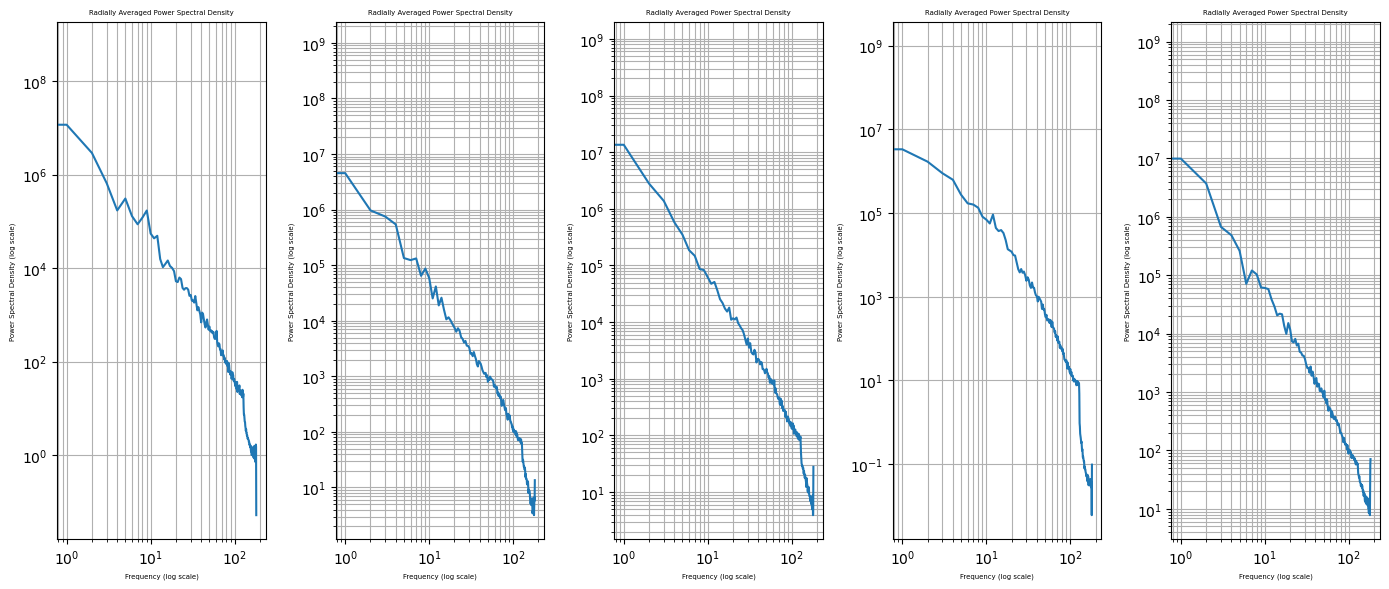

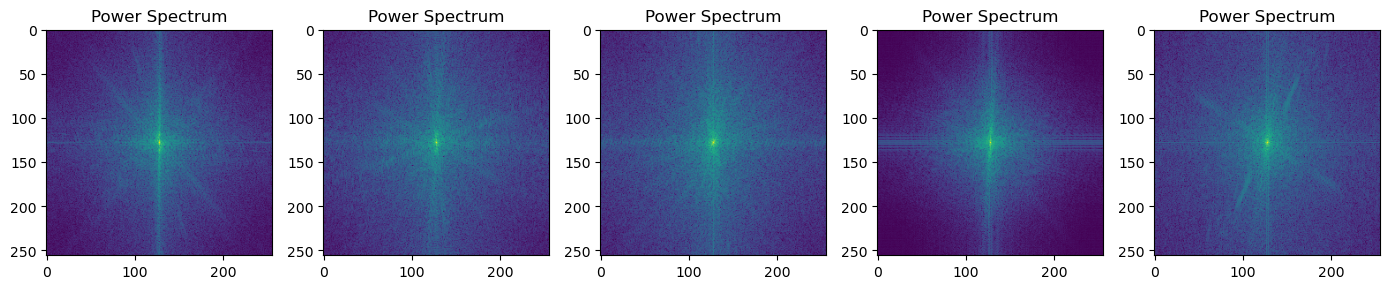

In [79]:
# Plotting

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow(transformed_synth_cars[k]['image'])
  plt.title("Transformed Image", size=8)
  plt.axis('off')
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.plot(freqs, pow_spec_all[k]) 
  plt.xscale("log")
  plt.yscale("log")
  plt.xlabel("Frequency (log scale)", size=5)
  plt.ylabel("Power Spectral Density (log scale)", size=5)
  plt.title("Radially Averaged Power Spectral Density", size=5)
  plt.grid(which="both")
  plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for k in range(num_displayed_examples):
  plt.subplot(1, num_displayed_examples, k + 1)
  plt.imshow(spec_all[k])
  plt.title("Power Spectrum")
  plt.tight_layout()
plt.show()



